# 10 forcasting time series data

In [104]:
import zipfile
import urllib.request
import random
import os
import pathlib
import datetime
import numpy as np
import pandas as pd
import io
import string

from helper_functions import create_tensorboard_callback, unzip_data, plot_loss_curves, compare_historys, calculate_results, plot_time_series

import matplotlib.pylab as plt
import matplotlib.image as mpimg

import tensorflow as tf
import tensorflow_hub as hub
import keras
from keras.layers import TextVectorization
from keras import layers
from keras.layers import preprocessing
from keras.utils import plot_model

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, minmax_scale

In [2]:
# url = "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv"
# filename= "BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv"
# file = urllib.request.urlretrieve(url,filename)

In [3]:
df = pd.read_csv("./data/BTC/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"])
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [4]:
bitcoin_prices = pd.DataFrame(
    df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices

,Price
Date,
2013-10-01,123.654990
2013-10-02,125.455000
2013-10-03,108.584830
2013-10-04,118.674660
2013-10-05,121.338660
...,...
2021-05-14,49764.132082
2021-05-15,50032.693137
2021-05-16,47885.625255


<AxesSubplot: xlabel='Date'>

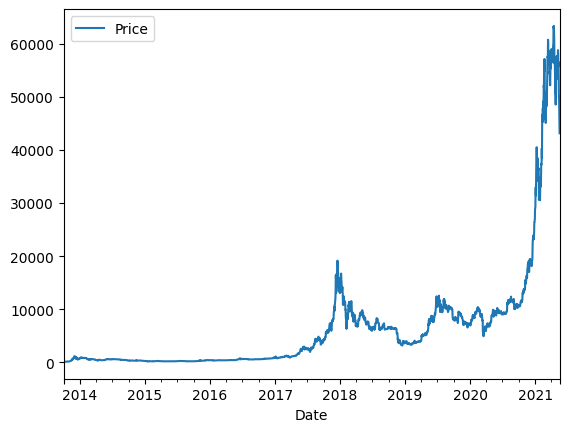

In [5]:
bitcoin_prices.plot()

## creating train and test sets for our data

In [6]:
timesteps = bitcoin_prices.index.to_numpy()
btc_prices = bitcoin_prices.Price.to_numpy()
timesteps[:10]
btc_prices[:10]
# fyi i think he doesnt see that btc_prices has extra whitespace...

array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  , 123.033  , 124.049  , 125.96116])

In [9]:
split_size = int(0.8 * len(btc_prices))
X_train, y_train = timesteps[:split_size], btc_prices[:split_size]

X_test, y_test = timesteps[split_size:], btc_prices[split_size:]

len(X_train), len(X_test)

(2229, 558)

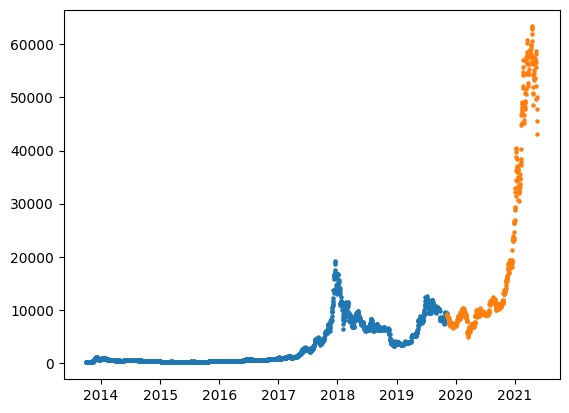

In [10]:
plt.scatter(X_train, y_train, s=5, label="train data")
plt.scatter(X_test, y_test, s=5, label="train data")
plt.show()

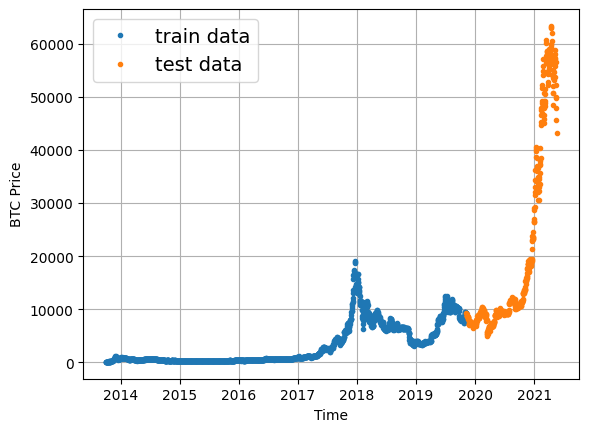

In [11]:
plot_time_series(X_train, y_train, label="train data")
plot_time_series(X_test, y_test, label="test data")


## MASE funciton

In [12]:
# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
    """
  Implement MASE (assuming no seasonality of data).
  """
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))

    # Find MAE of naive forecast (no seasonality)
    mae_naive_no_season = tf.reduce_mean(tf.abs(
        y_true[1:] -
        y_true[:-1]))  # our seasonality is 1 day (hence the shifting of 1 day)

    return mae / mae_naive_no_season


def evaluate_preds(y_true, y_pred):
    # Make sure float32 (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(
        y_true,
        y_pred)  # puts and emphasis on outliers (all errors get squared)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)

    return {
        "mae": mae.numpy(),
        "mse": mse.numpy(),
        "rmse": rmse.numpy(),
        "mape": mape.numpy(),
        "mase": mase.numpy()
    }


## formating data

In [13]:
HORIZON = 1
WINDOW_SIZE = 7


# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
    """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
    return x[:, :-horizon], x[:, -horizon:]


In [14]:
test_window, test_label = get_labelled_windows(
    tf.expand_dims(tf.range(8) + 1, axis=0))
test_window, test_label


2023-02-23 17:24:20.055756: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>,
 <tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[8]], dtype=int32)>)

In [15]:
# Create function to view NumPy arrays as windows
def make_windows(x, window_size=7, horizon=1):
    """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
    # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
    window_step = np.expand_dims(np.arange(window_size + horizon), axis=0)
    # print(f"Window step:\n {window_step}")

    # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
    window_indexes = window_step + np.expand_dims(
        np.arange(len(x) - (window_size + horizon - 1)),
        axis=0).T  # create 2D array of windows of size window_size
    # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

    # 3. Index on the target array (time series) with 2D array of multiple window steps
    windowed_array = x[window_indexes]

    # 4. Get the labelled windows
    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

    return windows, labels


In [17]:
full_windows, full_labels = make_windows(btc_prices)
len(full_labels), len(full_labels)

(2780, 2780)

In [18]:
for i in range(3):
    print(full_windows[i], full_labels[i])


[123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] [123.033]
[125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] [124.049]
[108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] [125.96116]


## turning windows into train and test

the below cell is dumb... you dont need this theres built in functions for this already....

In [19]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
    """
  Splits matching pairs of windows and labels into train and test splits.
  """
    split_size = int(
        len(windows) *
        (1 - test_split))  # this will default to 80% train/20% test
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels


In [20]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(
    full_windows, full_labels)


In [22]:
train_windows[1]

array([125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
       123.033  ])

## making modeling checkpoint

In [62]:
# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="./saves/10/"):
    return tf.keras.callbacks.ModelCheckpoint(
        filepath=save_path + "/" + model_name + "/" +
        model_name,  # create filepath to save model
        save_weights_only=True,
        verbose=1,  # only output a limited amount of text
        save_best_only=True)  # save only the best model to file


## model_1 dense model window=7 horizon=1

In [64]:
tf.random.set_seed(42)

model_1 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear"),
],
                              name="model_1_dense")

model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

model_1.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_1.name)])


Epoch 1/100
11/18 [=================>............] - ETA: 0s - loss: 1480.9569 - mae: 1480.9569
Epoch 1: val_loss improved from inf to 2864.56836, saving model to ./saves/10//model_1_dense/model_1_dense
18/18 [==============================] - 2s 36ms/step - loss: 1072.0831 - mae: 1072.0831 - val_loss: 2864.5684 - val_mae: 2864.5684
Epoch 2/100
14/18 [======================>.......] - ETA: 0s - loss: 329.6384 - mae: 329.6384
Epoch 2: val_loss improved from 2864.56836 to 1169.84692, saving model to ./saves/10//model_1_dense/model_1_dense
18/18 [==============================] - 0s 18ms/step - loss: 310.5162 - mae: 310.5162 - val_loss: 1169.8469 - val_mae: 1169.8469
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 148.3363 - mae: 148.3363
Epoch 3: val_loss did not improve from 1169.84692
18/18 [==============================] - 0s 5ms/step - loss: 220.8676 - mae: 220.8676 - val_loss: 1181.7379 - val_mae: 1181.7379
Epoch 4/100
 1/18 [>.............................] - E

In [65]:
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 684.9349 - mae: 684.9349


[684.9349365234375, 684.9349365234375]

In [69]:
# use best weights checkpoint
model_1.load_weights(f"./saves/10/model_1_dense/{model_1.name}")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 567.4031 - mae: 567.4031


[567.403076171875, 567.403076171875]

In [71]:
def make_preds(model, input_data):
    """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model 
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
    forecast = model.predict(input_data)
    return tf.squeeze(forecast)  # return 1D array of predictions


In [72]:
model_1_preds = make_preds(model_1, test_windows)
model_1_preds[:5]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=array([8873.294, 8808.056, 9052.397, 8785.889, 8769.793], dtype=float32)>

## model_2 dense (window=30 horizon=1)

In [74]:
WINDOW_SIZE = 30
full_windows, full_labels = make_windows(btc_prices, WINDOW_SIZE)


In [75]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(
    windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [78]:
tf.random.set_seed(42)

model_2 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear"),
],
                              name="model_2_dense")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_2.name)])


Epoch 1/100
 1/18 [>.............................] - ETA: 8s - loss: 3155.7153 - mae: 3155.7153
Epoch 1: val_loss improved from inf to 3181.58008, saving model to ./saves/10//model_2_dense/model_2_dense
18/18 [==============================] - 1s 13ms/step - loss: 1103.6805 - mae: 1103.6805 - val_loss: 3181.5801 - val_mae: 3181.5801
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 570.0815 - mae: 570.0815
Epoch 2: val_loss improved from 3181.58008 to 2121.22681, saving model to ./saves/10//model_2_dense/model_2_dense
18/18 [==============================] - 0s 14ms/step - loss: 376.8144 - mae: 376.8144 - val_loss: 2121.2268 - val_mae: 2121.2268
Epoch 3/100
 9/18 [==============>...............] - ETA: 0s - loss: 303.7289 - mae: 303.7289
Epoch 3: val_loss improved from 2121.22681 to 1423.40552, saving model to ./saves/10//model_2_dense/model_2_dense
18/18 [==============================] - 0s 21ms/step - loss: 293.2628 - mae: 293.2628 - val_loss: 1423.4055 - val_mae:

## model_3 dense window = 30 horizon = 7

In [79]:
WINDOW_SIZE = 30
HORIZON = 7
full_windows, full_labels = make_windows(btc_prices,
                                         WINDOW_SIZE,
                                         horizon=HORIZON)
len(full_windows), len(full_labels)


(2751, 2751)

In [80]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(
    windows=full_windows, labels=full_labels)


In [81]:
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON),
],
                              name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

model_3.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_3.name)])


Epoch 1/100
 1/18 [>.............................] - ETA: 10s - loss: 2623.6948 - mae: 2623.6948
Epoch 1: val_loss improved from inf to 2606.49707, saving model to ./saves/10//model_3_dense/model_3_dense
18/18 [==============================] - 1s 13ms/step - loss: 1182.5363 - mae: 1182.5363 - val_loss: 2606.4971 - val_mae: 2606.4971
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 393.9960 - mae: 393.9960
Epoch 2: val_loss improved from 2606.49707 to 2305.15210, saving model to ./saves/10//model_3_dense/model_3_dense
18/18 [==============================] - 0s 7ms/step - loss: 476.1976 - mae: 476.1976 - val_loss: 2305.1521 - val_mae: 2305.1521
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 393.1249 - mae: 393.1249
Epoch 3: val_loss improved from 2305.15210 to 2139.01318, saving model to ./saves/10//model_3_dense/model_3_dense
18/18 [==============================] - 0s 7ms/step - loss: 385.9485 - mae: 385.9485 - val_loss: 2139.0132 - val_mae: 

## model_4 Conv1D

In [82]:
HORIZON = 1
WINDOW_SIZE = 7

full_windows, full_labels = make_windows(btc_prices,
                                         WINDOW_SIZE,
                                         horizon=HORIZON)

train_windows, test_windows, train_labels, test_labels = make_train_test_splits(
    windows=full_windows, labels=full_labels)


In [83]:
train_windows[0].shape

(7,)

before we pass our data to conv1d layer we have to reshape it to work

In [84]:
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])>

In [88]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))


In [90]:
print(f"original: {x}")
print(f"original: {x.shape}")
print(f"expanded shape: {expand_dims_layer(x).shape}")
print(f"original with expanded shape: {expand_dims_layer(x)}")

original: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ]
original: (7,)
expanded shape: (7, 1)
original with expanded shape: [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [91]:
tf.random.set_seed(42)

model_4 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    layers.Conv1D(
        128, activation="relu", kernel_size=5, strides=1, padding="causal"),
    layers.Dense(HORIZON),
],
                              name="model_4_conv1d")

model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

model_4.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_4.name)])


Epoch 1/100
18/18 [==============================] - ETA: 0s - loss: 2049.0298 - mae: 2049.0298
Epoch 1: val_loss improved from inf to 2620.25610, saving model to ./saves/10//model_4_conv1d/model_4_conv1d
18/18 [==============================] - 1s 37ms/step - loss: 2049.0298 - mae: 2049.0298 - val_loss: 2620.2561 - val_mae: 2620.2561
Epoch 2/100
12/18 [===================>..........] - ETA: 0s - loss: 359.0080 - mae: 359.0080
Epoch 2: val_loss improved from 2620.25610 to 1424.57959, saving model to ./saves/10//model_4_conv1d/model_4_conv1d
18/18 [==============================] - 0s 17ms/step - loss: 318.4798 - mae: 318.4798 - val_loss: 1424.5796 - val_mae: 1424.5796
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 186.7054 - mae: 186.7054
Epoch 3: val_loss improved from 1424.57959 to 1026.67651, saving model to ./saves/10//model_4_conv1d/model_4_conv1d
18/18 [==============================] - 0s 7ms/step - loss: 215.4766 - mae: 215.4766 - val_loss: 1026.6765 - val

In [92]:
model_4.summary()

Model: "model_4_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_40 (Dense)            (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [93]:
model_4.evaluate(test_windows, test_labels)


18/18 [==============================] - 0s 3ms/step - loss: 660.8000 - mae: 660.8000


[660.800048828125, 660.800048828125]

## model_5 RNN (LSTM)

In [98]:
tf.random.set_seed(42)

inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(128, activation="relu")(x)
outputs = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs, outputs=outputs, name="model_5_lstm")

model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

model_5.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_5.name)])


Epoch 1/100
14/18 [======================>.......] - ETA: 0s - loss: 2739.9277 - mae: 2739.9277 
Epoch 1: val_loss improved from inf to 10974.82812, saving model to ./saves/10//model_5_lstm/model_5_lstm
18/18 [==============================] - 3s 23ms/step - loss: 2613.0273 - mae: 2613.0273 - val_loss: 10974.8281 - val_mae: 10974.8281
Epoch 2/100
13/18 [====================>.........] - ETA: 0s - loss: 1136.1042 - mae: 1136.1042
Epoch 2: val_loss improved from 10974.82812 to 1085.40137, saving model to ./saves/10//model_5_lstm/model_5_lstm
18/18 [==============================] - 0s 9ms/step - loss: 921.3350 - mae: 921.3350 - val_loss: 1085.4014 - val_mae: 1085.4014
Epoch 3/100
11/18 [=================>............] - ETA: 0s - loss: 281.2699 - mae: 281.2699
Epoch 3: val_loss did not improve from 1085.40137
18/18 [==============================] - 0s 7ms/step - loss: 252.5538 - mae: 252.5538 - val_loss: 1306.4399 - val_mae: 1306.4399
Epoch 4/100
17/18 [===========================>..] -

## make multivariate time series dataset

In [99]:
block_reward_2 = 25
block_reward_3 = 12.5
block_reward_4 = 6.25

block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

In [101]:
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days

In [102]:
# Add block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block_reward column (it's the last column hence -1 indexing on iloc)
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days,
                          -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


<AxesSubplot: xlabel='Date'>

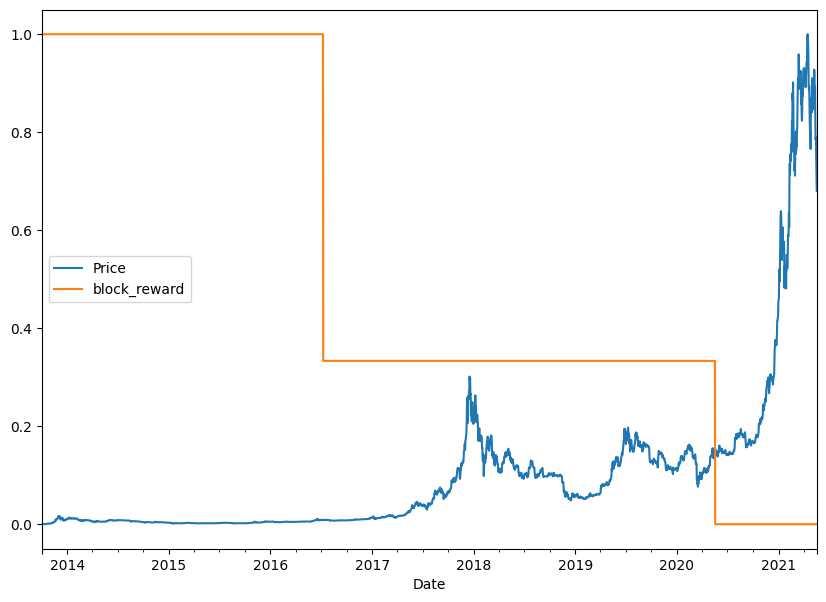

In [105]:
# Plot the block reward/price over time
# Note: Because of the different scales of our values we'll scale them to be between 0 and 1.
scaled_price_block_df = pd.DataFrame(
    minmax_scale(bitcoin_prices_block[["Price", "block_reward"
                                       ]]),  # we need to scale the data first
    columns=bitcoin_prices_block.columns,
    index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7))

In [106]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE):  # Shift values for each step in WINDOW_SIZE
    bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed[
        "Price"].shift(periods=i + 1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [107]:
# Let's create X & y, remove the NaN's and convert to float32 to prevent TensorFlow errors
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()


,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [108]:
# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

## model_6 Dense Multivariate model

In [109]:
tf.random.set_seed(42)

model_6 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear"),
],
                              name="model_6_dense_multivar")

model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

model_6.fit(X_train,
            y_train,
            epochs=100,
            batch_size=128,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_6.name)])


Epoch 1/100
10/18 [===============>..............] - ETA: 0s - loss: 3639.9133 - mae: 3639.9133 
Epoch 1: val_loss improved from inf to 7555.65039, saving model to ./saves/10//model_6_dense_multivar/model_6_dense_multivar
18/18 [==============================] - 2s 47ms/step - loss: 2984.6279 - mae: 2984.6279 - val_loss: 7555.6504 - val_mae: 7555.6504
Epoch 2/100
15/18 [========================>.....] - ETA: 0s - loss: 509.1732 - mae: 509.1732
Epoch 2: val_loss improved from 7555.65039 to 1734.52747, saving model to ./saves/10//model_6_dense_multivar/model_6_dense_multivar
18/18 [==============================] - 0s 25ms/step - loss: 496.6994 - mae: 496.6994 - val_loss: 1734.5275 - val_mae: 1734.5275
Epoch 3/100
 9/18 [==============>...............] - ETA: 0s - loss: 234.8860 - mae: 234.8860
Epoch 3: val_loss improved from 1734.52747 to 1118.17493, saving model to ./saves/10//model_6_dense_multivar/model_6_dense_multivar
18/18 [==============================] - 0s 19ms/step - loss: 23

## Model_7 N-BEATS algo

In [110]:
# Create NBeatsBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):

    def __init__(
        self,  # the constructor takes all the hyperparameters for the layer
        input_size: int,
        theta_size: int,
        horizon: int,
        n_neurons: int,
        n_layers: int,
        **kwargs
    ):  # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
        super().__init__(**kwargs)
        self.input_size = input_size
        self.theta_size = theta_size
        self.horizon = horizon
        self.n_neurons = n_neurons
        self.n_layers = n_layers

        # Block contains stack of 4 fully connected layers each has ReLU activation
        self.hidden = [
            tf.keras.layers.Dense(n_neurons, activation="relu")
            for _ in range(n_layers)
        ]
        # Output of block is a theta layer with linear activation
        self.theta_layer = tf.keras.layers.Dense(theta_size,
                                                 activation="linear",
                                                 name="theta")

    def call(self,
             inputs):  # the call method is what runs when the layer is called
        x = inputs
        for layer in self.hidden:  # pass inputs through each hidden layer
            x = layer(x)
        theta = self.theta_layer(x)
        # Output the backcast and forecast from theta
        backcast, forecast = theta[:, :self.input_size], theta[:,
                                                               -self.horizon:]
        return backcast, forecast


In [111]:
dummy_nbeats_block_layer = NBeatsBlock(
    input_size=WINDOW_SIZE,
    theta_size=WINDOW_SIZE + HORIZON,
    horizon=HORIZON,
    n_neurons=128,
    n_layers=4,
)

In [113]:
# creating some dummy inputs
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [119]:
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
backcast

<tf.Tensor: shape=(1, 7), dtype=float32, numpy=
array([[-0.23995999,  1.0135219 , -0.23360425,  0.15807968, -0.06819643,
         0.9365648 , -0.03097062]], dtype=float32)>

## Preparing data for N-Beats Algo

In [120]:
HORIZON = 1
WINDOW_SIZE = 7

bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
    bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats.Price.shift(
        periods=i + 1)

bitcoin_prices_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-01,123.65499,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [121]:
# make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# make train and test splits
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(X_test)

(2224, 556)

In [122]:
# we havnt made our datasets performate so far cuz datasets have been fairly small but now we should by using tf.data api
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip(
    (train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip(
    (test_features_dataset, test_labels_dataset))

BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset


(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [123]:
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE * HORIZON

In [124]:
# Setup instance of nbeatsblock
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# create input to stack layer
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# create initial backcast and forecast input
residuals, forecast = nbeats_block_layer(stack_input)

# create stacks of block layers
for i, _ in enumerate(range(N_STACKS - 1)):
    backcast, block_forecast = NBeatsBlock(input_size=INPUT_SIZE,
                                           theta_size=THETA_SIZE,
                                           horizon=HORIZON,
                                           n_neurons=N_NEURONS,
                                           n_layers=N_LAYERS,
                                           name=f"NBeatsBlock_{i}")(residuals)
    residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
    forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

model_7 = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_7_nbeats")

model_7.compile(loss="mae", optimizer=tf.keras.optimizers.Adam())

model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            callbacks=[
                tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                 patience=200,
                                                 restore_best_weights=True),
                tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                     patience=100,
                                                     verbose=1)
            ])


Epoch 1/5000
3/3 [==============================] - 29s 2s/step - loss: 12119.3447 - val_loss: 15044.7129 - lr: 0.0010
Epoch 2/5000
3/3 [==============================] - 3s 996ms/step - loss: 1849.2184 - val_loss: 18843.1504 - lr: 0.0010
Epoch 3/5000
3/3 [==============================] - 3s 950ms/step - loss: 2816.4304 - val_loss: 11720.5635 - lr: 0.0010
Epoch 4/5000
3/3 [==============================] - 3s 991ms/step - loss: 2032.3759 - val_loss: 2831.1826 - lr: 0.0010
Epoch 5/5000
3/3 [==============================] - 3s 987ms/step - loss: 288.1413 - val_loss: 1632.8208 - lr: 0.0010
Epoch 6/5000
3/3 [==============================] - 3s 986ms/step - loss: 621.7042 - val_loss: 1405.4771 - lr: 0.0010
Epoch 7/5000
3/3 [==============================] - 3s 956ms/step - loss: 295.6120 - val_loss: 2088.9395 - lr: 0.0010
Epoch 8/5000
3/3 [==============================] - 3s 946ms/step - loss: 576.9362 - val_loss: 3496.1917 - lr: 0.0010
Epoch 9/5000
3/3 [==============================] 

## model_8 Ensemble Model

the below cell is the function to create ensemble models. but my pc would take ages to run that so im skipping it.

In [125]:
def get_ensemble_models(horizon=HORIZON, 
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10, 
                        num_epochs=100, 
                        loss_fns=["mae", "mse", "mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned:
  10 * len(["mae", "mse", "mape"]).
  """
  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
        # Initialize layers with normal (Gaussian) distribution so we can use the models for prediction
        # interval estimation later: https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"), 
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON)                                 
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])
      
      # Fit model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                # Add callbacks to prevent training from going/stalling for too long
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])
      
      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models # return list of trained models